In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics



In [2]:
def spatial_merge_left_join(plants_df, atmospheric_df):
    
    gdf_plants = gpd.GeoDataFrame(
        plants_df,
        geometry=gpd.points_from_xy(plants_df.Longitude, plants_df.Latitude),
        crs="EPSG:4326"
    )
    
    gdf_atmospheric = gpd.GeoDataFrame(
        atmospheric_df,
        geometry=gpd.points_from_xy(atmospheric_df.LONGITUDE, atmospheric_df.LATITUDE),
        crs="EPSG:4326"
    )

    LOCAL_CRS = "EPSG:5070" 
    gdf_plants_proj = gdf_plants.to_crs(LOCAL_CRS)
    gdf_atmospheric_proj = gdf_atmospheric.to_crs(LOCAL_CRS)

    power_plants_merged_gdf = gpd.sjoin_nearest(
        gdf_plants_proj, 
        gdf_atmospheric_proj,
        how="left", 
        distance_col="distance_meters"
    )
    
    power_plants_merged_gdf['distance_to_match'] = power_plants_merged_gdf['distance_meters'] / 1000.0

    final_df = pd.DataFrame(power_plants_merged_gdf.drop(columns=['geometry', 'index_right', 'distance_meters']))

    return final_df


def plot_map(map_title,
             x,
             y,
             c='blue',
             labels=None,
             cmap=False,
             s=1,
             edgecolor=None,
             linewidths=None,
             alpha=1,
             zorder=1):
    fig = plt.figure(figsize=(20,9))

    _map = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

    _map.stock_img()

    _map.add_feature(cfeature.LAND, color='lightgray')

    _map.add_feature(cfeature.OCEAN, color='lightblue')

    _map.add_feature(cfeature.COASTLINE)

    _map.add_feature(cfeature.BORDERS, linestyle=':')

    _map.add_feature(cfeature.LAKES, alpha=0.5, color='lightblue')

    _map.add_feature(cfeature.RIVERS)

    if cmap:
        if edgecolor is not None:
            _map.scatter(x,
                         y,
                         c=c,
                         s=s,
                         cmap=cmap,
                         edgecolor=edgecolor,
                         linewidths=linewidths,
                         alpha=alpha,
                         zorder=zorder,
                         transform=ccrs.PlateCarree())
            
        else:
            _map.scatter(x,
                         y,
                         c=c,
                         s=s,
                         cmap=cmap,
                         alpha=alpha,
                         zorder=zorder,
                         transform=ccrs.PlateCarree())
        
    else:
        _map.scatter(x,
                     y,
                     c=c,
                     s=s,
                     alpha=alpha,
                     zorder=zorder,
                     transform=ccrs.PlateCarree())

    gl = _map.gridlines(draw_labels=True,
                        dms=True,
                        x_inline=False,
                        y_inline=False,
                        color='gray',
                        linestyle='--')

    gl.top_labels = False

    gl.right_labels = False
    
    handles = []

    if labels is not None:
        for i, category in enumerate(categories):
            handle = mlines.Line2D([], [], color=cmap(i), marker='o', linestyle='None',
                              markersize=10, label=category)

            handles.append(handle)

        _map.legend(handles=handles, title=f"{map_title}", bbox_to_anchor=(0, 0), loc='lower left')

    _map.set_title(f"{map_title}")

    plt.show()

# =============================================================================
# Code generated by Artificial Intelligence (Google AI)
# Date: 2025-12-05
# Prompt: "Python function to convert degrees F to degrees C"
# =============================================================================
def fahrenheit_to_celsius(fahrenheit_temp):
    """
    Converts a temperature from Fahrenheit (°F) to Celsius (°C).
    """
    celsius_temp = (fahrenheit_temp - 32) * 5/9
    return celsius_temp

# =============================================================================
# Code generated by Artificial Intelligence (Google AI)
# Date: 2025-12-05
# Prompt: "Python function to calculate relative humidity from NCEI dataset."
# =============================================================================
def calculate_relative_humidity(x):
    """
    Calculates relative humidity (%) using the Magnus approximation and accounts for pressure.
    
    Args:
        temperature_celsius (float): The current ambient air temperature in Celsius.
        dew_point_celsius (float): The dew point temperature in Celsius.
        station_pressure_hpa (float): The actual pressure at the station level in Hectopascals (hPa) or millibars (mb).
        
    Returns:
        float: The calculated relative humidity as a percentage.
    """
    
    temperature_celsius = x['TEMP_C']
    
    dew_point_celsius = x['DEWP']
    
    station_pressure_hpa = x['STP']
    
    # 1. Calculate Saturation Vapor Pressure (es) at current T (Magnus-Tetens formula)
    # Constants used for water vapor over water
    A = 17.625
    B = 243.04
    es = 6.112 * np.exp((A * temperature_celsius) / (B + temperature_celsius))
    # 2. Calculate Actual Vapor Pressure (e) at Td (e is es at dew point)
    e = 6.112 * np.exp((A * dew_point_celsius) / (B + dew_point_celsius))
    # 3. Apply the Enhancement Factor (f) - This is where pressure comes in
    # This factor corrects for the behavior of moist air at different pressures.
    f = 1 + (1e-6 * station_pressure_hpa * (4.5 + 6e-4 * temperature_celsius**2))
    # 4. Calculate RH
    # RH = (e / (f * es)) * 100
    # For most standard uses, f is very close to 1, and often omitted. 
    # The calculation is robust without it, but more reliable with it.
    
    RH = (e / (f * es)) * 100
    
    # Constrain the result to physical limits
    RH = max(0, min(100, RH))
    return RH

<h3>Step 3: Integrate Discovered Features into Predictive Models</h3>

Take the features you discovered in Phase 1 (cluster memberships, principal components, or derived features) and integrate them into your predictive models. You have options:

If you did clustering:

[x]Add cluster membership as a new feature in your prediction models.<br>
OR[ ]predict within each cluster separately.<br>
OR[ ]use clusters to create new engineered features (e.g., "distance from cluster center").<br>


In [3]:
ncei_stations_id = pd.read_csv('data/ncei_stations_id.csv', index_col=0)

In [4]:
monthly_pivot = pd.read_csv('data/monthly_pivot.csv', index_col=0)

In [5]:
power_plants = pd.read_csv('data/power_plant_distance_to_water.csv', index_col=0)

In [6]:
ncei_atmospheric_aggregate = pd.read_csv('data/ncei_atmospheric_aggregate.csv', index_col=0)

In [7]:
full_atmospheric_w_id = pd.read_csv('data/full_atmospheric_w_id.csv', index_col=0)

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_67147/3299351841.py:1: DtypeWarning: Columns (135) have mixed types. Specify dtype option on import or set low_memory=False.
  full_atmospheric_w_id = pd.read_csv('data/full_atmospheric_w_id.csv', index_col=0)


In [8]:
monthly_pivot_w_stations = monthly_pivot.merge(ncei_stations_id, on='NAME', how='left')

# data quality issue
monthly_pivot_w_stations = monthly_pivot_w_stations.dropna()

monthly_pivot_w_stations

,NAME,1_TEMP,2_TEMP,3_TEMP,4_TEMP,5_TEMP,6_TEMP,7_TEMP,8_TEMP,9_TEMP,...,11_PRCP,12_PRCP,CLIMATE ZONE n_clusters=2,CLIMATE ZONE n_clusters=5,CLIMATE ZONE n_clusters=11,CLIMATE ZONE n_clusters=31,STATION,LATITUDE,LONGITUDE,ELEVATION
0,"068 BAFFIN BAY POINT OF ROCKS TX, TX US",55.030645,61.121053,67.901724,73.383333,79.854098,83.390000,82.854839,84.477778,81.543333,...,0.000000,0.000000,1,0,2,25,99471099999,27.300000,-97.420000,4.00
1,"9014098 FORT GRATIOT MI, US",24.872581,29.710714,39.132759,46.596491,55.336066,67.819643,71.725806,71.140741,66.320000,...,0.000000,0.000000,0,1,1,3,99725899999,43.010000,-82.420000,180.10
2,"9052030 OSWEGO NY, US",27.512903,30.026786,39.381034,46.408929,57.111475,67.585000,73.332258,70.574074,65.746667,...,0.000000,0.000000,0,1,1,3,99726499999,43.460000,-76.510000,78.00
3,"9063020 BUFFALO NY, US",27.285484,29.584211,37.920690,45.516667,57.940984,67.696667,73.688710,71.751852,67.973333,...,0.000000,0.000000,0,1,6,24,99725499999,42.880000,-78.890000,178.30
4,"9075014 HARBOR BEACH MI, US",24.391935,28.058929,35.505172,43.260000,51.595082,63.859322,69.646774,69.653704,65.363333,...,0.000000,0.000000,0,1,1,3,99726099999,43.850000,-82.640000,179.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10790,"ZUZ AGAC, KZ",15.324194,10.101754,31.634483,54.991379,66.526230,78.343333,78.760656,75.285185,57.006667,...,0.000000,0.000000,0,1,1,23,36619099999,47.083000,79.717000,422.00
10791,"ZVARTNOTS, AM",32.725806,35.492982,47.843103,59.543333,65.206557,76.141667,81.319355,83.433333,72.013333,...,0.000000,0.000000,0,3,6,1,35394699999,40.147275,44.395881,865.02
10792,"ZWERNDORF MARCHEGG, AU",34.679032,40.815789,46.835714,54.405000,58.822414,69.423729,71.670968,72.142593,63.316667,...,0.005789,0.016000,0,1,6,17,11085099999,48.333333,16.833333,146.00
10793,"ZYRJANOVSK, KZ",0.174194,-6.657895,15.960345,42.058621,57.152459,67.063333,67.722581,62.970370,47.553333,...,0.000000,0.000000,0,4,8,13,36421099999,49.750000,84.283000,492.00


In [9]:
merged_df = spatial_merge_left_join(power_plants, monthly_pivot_w_stations)

merged_df = merged_df.groupby('gppd_idnr').first()

merged_df

,Powerplant Name,Capacity (MW),Primary Fuel,Owner,Source,distance_to_water_km,Longitude,Latitude,NAME,1_TEMP,...,12_PRCP,CLIMATE ZONE n_clusters=2,CLIMATE ZONE n_clusters=5,CLIMATE ZONE n_clusters=11,CLIMATE ZONE n_clusters=31,STATION,LATITUDE,LONGITUDE,ELEVATION,distance_to_match
gppd_idnr,,,,,,,,,,,,,,,,,,,,,
ARG0000001,PARANA,845.26,Other,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.581258,-60.1718,-33.3549,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,101.088586
ARG0000002,SAN NICOLAS,644.00,Coal,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.721664,-60.1729,-33.3562,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,100.948114
ARG0000003,CT ARRECIFES,20.00,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,41.358227,-60.1297,-34.0414,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,127.363341
ARG0000004,CT GENERAL VILLEGAS,23.49,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,156.359842,-62.9981,-35.0347,"LABOULAYE, AR",79.900000,...,0.000000,1,2,9,22,87534099999,-34.135444,-63.362250,136.85,81.643097
ARG0000005,CT MAGDALENA,25.00,Oil,APR ENERGY SRL,Ministerio de Energía y Minería,0.000000,-57.4839,-35.1001,"PUNTA INDIO B.A., AR",77.449057,...,0.000000,1,2,9,22,87596099999,-35.366667,-57.283333,16.00,36.111470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRI1075859,Vidin Works power station,120.00,Coal,Vidachim,GCPT,1.213469,22.8509,43.9484,"VIDIN, BU",35.304839,...,0.109333,0,1,6,1,15502099999,43.983333,22.850000,595.00,3.896562
WRI1075860,Kelvin power station,600.00,Coal,Aldwych International Ltd,GCPT,50.922046,28.1940,-26.1158,"PRETORIA IRENE, SF",70.473684,...,0.000000,1,2,9,22,68263099999,-25.910980,28.210450,1500.00,15.112102
WRI1075861,Pretoria West power station,180.00,Coal,None,GCPT,71.556524,28.1467,-25.7584,"PRETORIA UNISA, SF",71.439130,...,0.228571,1,2,9,22,68269099999,-25.766667,28.200000,1439.00,8.136565


In [10]:
merged_df[merged_df==np.nan].count().count()

42

In [11]:
# data quality issue
merged_df = merged_df.fillna(0)

merged_df[merged_df.isnull()].count().count()

42

In [12]:
merged_df

,Powerplant Name,Capacity (MW),Primary Fuel,Owner,Source,distance_to_water_km,Longitude,Latitude,NAME,1_TEMP,...,12_PRCP,CLIMATE ZONE n_clusters=2,CLIMATE ZONE n_clusters=5,CLIMATE ZONE n_clusters=11,CLIMATE ZONE n_clusters=31,STATION,LATITUDE,LONGITUDE,ELEVATION,distance_to_match
gppd_idnr,,,,,,,,,,,,,,,,,,,,,
ARG0000001,PARANA,845.26,Other,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.581258,-60.1718,-33.3549,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,101.088586
ARG0000002,SAN NICOLAS,644.00,Coal,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.721664,-60.1729,-33.3562,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,100.948114
ARG0000003,CT ARRECIFES,20.00,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,41.358227,-60.1297,-34.0414,"ROSARIO, AR",78.119355,...,0.000833,1,2,9,22,87480099999,-32.903611,-60.785000,25.90,127.363341
ARG0000004,CT GENERAL VILLEGAS,23.49,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,156.359842,-62.9981,-35.0347,"LABOULAYE, AR",79.900000,...,0.000000,1,2,9,22,87534099999,-34.135444,-63.362250,136.85,81.643097
ARG0000005,CT MAGDALENA,25.00,Oil,APR ENERGY SRL,Ministerio de Energía y Minería,0.000000,-57.4839,-35.1001,"PUNTA INDIO B.A., AR",77.449057,...,0.000000,1,2,9,22,87596099999,-35.366667,-57.283333,16.00,36.111470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRI1075859,Vidin Works power station,120.00,Coal,Vidachim,GCPT,1.213469,22.8509,43.9484,"VIDIN, BU",35.304839,...,0.109333,0,1,6,1,15502099999,43.983333,22.850000,595.00,3.896562
WRI1075860,Kelvin power station,600.00,Coal,Aldwych International Ltd,GCPT,50.922046,28.1940,-26.1158,"PRETORIA IRENE, SF",70.473684,...,0.000000,1,2,9,22,68263099999,-25.910980,28.210450,1500.00,15.112102
WRI1075861,Pretoria West power station,180.00,Coal,0,GCPT,71.556524,28.1467,-25.7584,"PRETORIA UNISA, SF",71.439130,...,0.228571,1,2,9,22,68269099999,-25.766667,28.200000,1439.00,8.136565


In [13]:
atmospheric_features = [
'DEWP', 'SLP','STP','VISIB','WDSP',
'MXSPD','GUST','MAX','MIN','RH'
]

In [14]:
ncei_atmospheric_aggregate[ncei_atmospheric_aggregate==999.9] = 0

ncei_atmospheric_aggregate[ncei_atmospheric_aggregate==9999.9] = 0

ncei_atmospheric_aggregate['TEMP_C'] = ncei_atmospheric_aggregate['TEMP'].apply(lambda x: fahrenheit_to_celsius(x))

ncei_atmospheric_aggregate['RH'] = ncei_atmospheric_aggregate.apply(lambda x: calculate_relative_humidity(x), axis=1)

In [15]:
pivot_df_full = []

numeric_features = ['distance_to_water_km']

for feature in atmospheric_features:
    tmp_pivot = ncei_atmospheric_aggregate.reset_index(drop=True).pivot_table(
    index='NAME',       # The row labels will be the station names
    columns='MONTH',    # The new columns will be the month numbers (1-12)
    values=f'{feature}',      # The data to fill the cells will come from the 'TEMP' column
    aggfunc='mean'      # If a station has multiple entries for a month, take the average
)
    
    atmospheric_features = [str(i)+f'_{feature}' for i in range(1,13)]
    
    tmp_pivot.columns = atmospheric_features
    
    numeric_features += atmospheric_features
    
    pivot_df_full.append(tmp_pivot)
    
pivot_df = pd.concat(pivot_df_full, axis=1)

pivot_df

,1_DEWP,2_DEWP,3_DEWP,4_DEWP,5_DEWP,6_DEWP,7_DEWP,8_DEWP,9_DEWP,10_DEWP,...,3_RH,4_RH,5_RH,6_RH,7_RH,8_RH,9_RH,10_RH,11_RH,12_RH
NAME,,,,,,,,,,,,,,,,,,,,,
"068 BAFFIN BAY POINT OF ROCKS TX, TX US",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,26.270606,21.801822,17.589654,15.680225,15.953613,15.14065,16.646593,18.440008,22.239984,28.083763
"9014098 FORT GRATIOT MI, US",17.369355,21.032143,28.501754,35.070175,47.540984,57.307143,62.862903,61.842593,57.203333,43.119355,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
"9052030 OSWEGO NY, US",20.354839,21.769643,28.750000,36.705357,49.491803,58.118333,64.325806,61.516667,57.693333,44.829032,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
"9063020 BUFFALO NY, US",21.066129,22.224561,28.906897,35.793333,49.927869,59.318333,64.848387,62.235185,57.813333,46.022581,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
"9075014 HARBOR BEACH MI, US",18.716129,21.766071,28.473684,35.200000,45.847541,56.649153,63.367742,62.846296,59.390000,44.306452,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ZUZ AGAC, KZ",9.070968,3.236842,22.362069,36.910345,45.088525,49.870000,51.400000,47.777778,37.710000,34.687097,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
"ZVARTNOTS, AM",24.332258,21.463158,27.998276,38.063333,44.995082,44.221667,51.429032,49.685185,47.730000,37.677419,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
"ZWERNDORF MARCHEGG, AU",28.974194,31.601754,35.644643,42.165000,47.496552,56.433898,57.645161,57.422222,51.110000,46.887097,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000


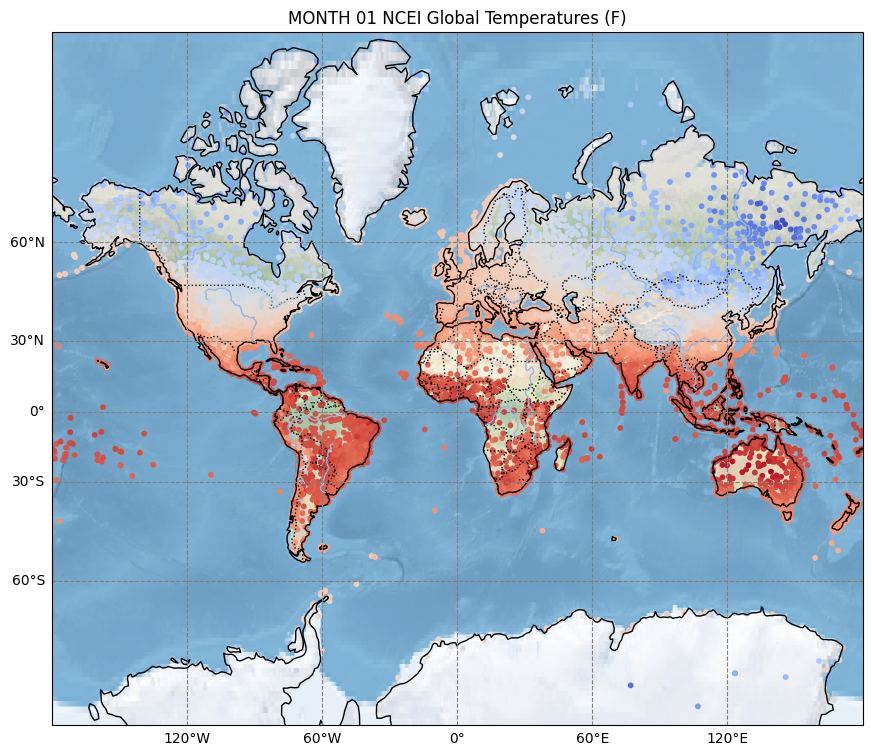

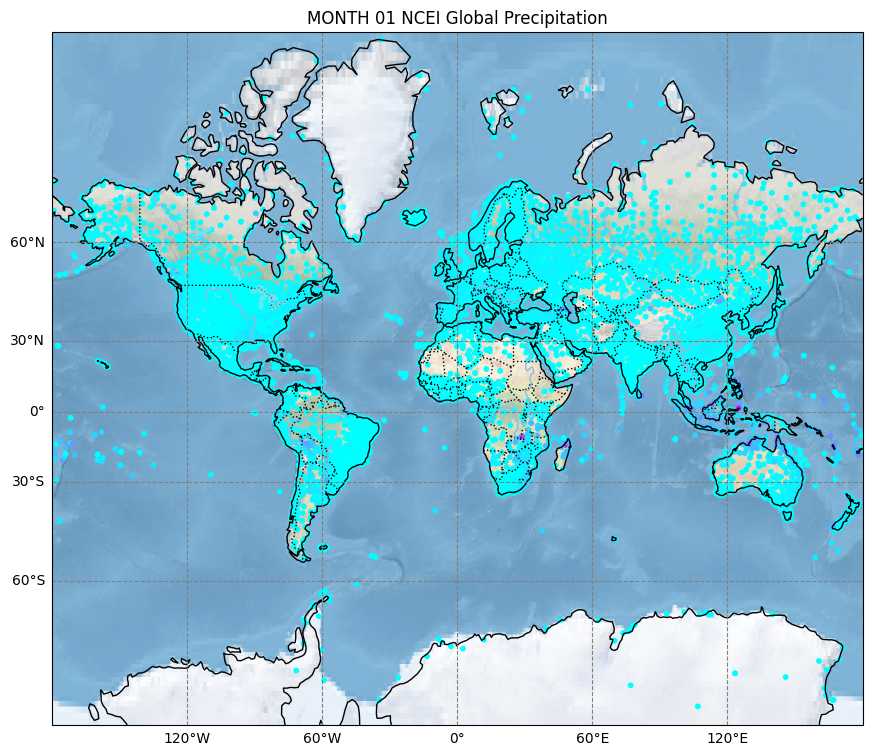

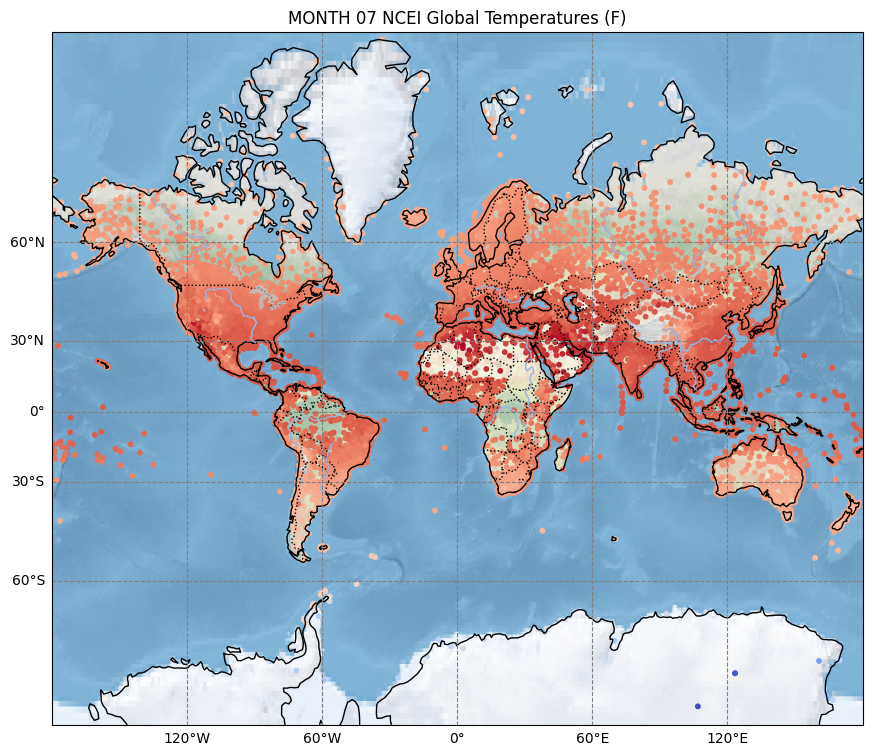

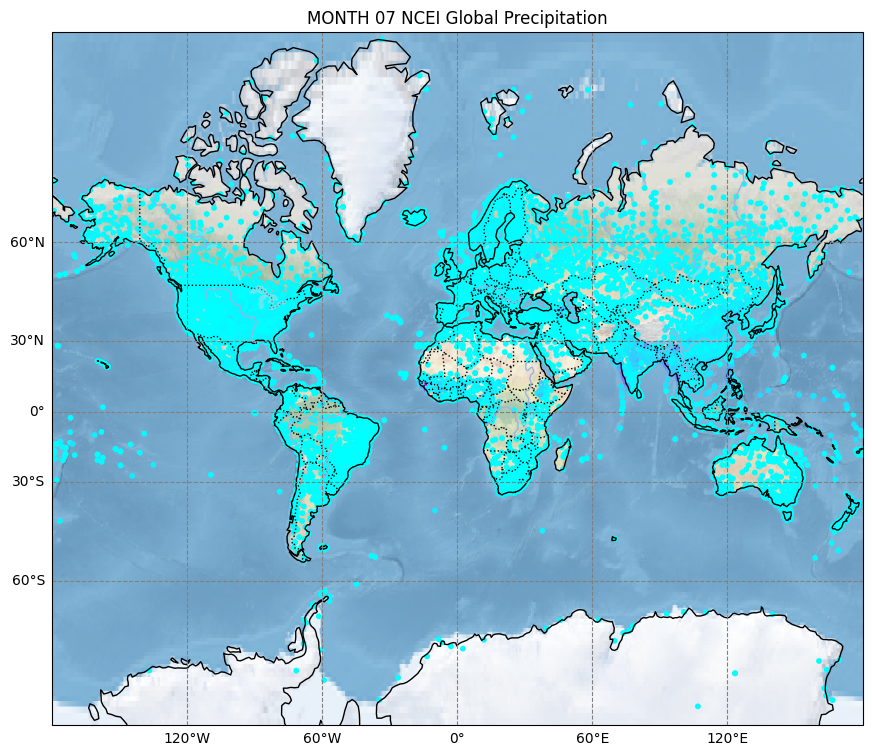

In [16]:
plot_map("MONTH 01 NCEI Global Temperatures (F)",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['1_TEMP'],
         labels=None,
         cmap='coolwarm',
         s=10)

plot_map("MONTH 01 NCEI Global Precipitation",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['1_PRCP'],
         labels=None,
         cmap='cool',
         s=10)

plot_map("MONTH 07 NCEI Global Temperatures (F)",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['7_TEMP'],
         labels=None,
         cmap='coolwarm',
         s=10)

plot_map("MONTH 07 NCEI Global Precipitation",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['7_PRCP'],
         labels=None,
         cmap='cool',
         s=10)

In [18]:
new_features = []

k_values = [2,5,11]

for n_clusters in k_values:
    new_features.append(f"CLIMATE ZONE n_clusters={n_clusters}")
    
print(new_features)

['CLIMATE ZONE n_clusters=2', 'CLIMATE ZONE n_clusters=5', 'CLIMATE ZONE n_clusters=11']


In [19]:
numeric_features_full = numeric_features + new_features

print(numeric_features_full)

['distance_to_water_km', '1_DEWP', '2_DEWP', '3_DEWP', '4_DEWP', '5_DEWP', '6_DEWP', '7_DEWP', '8_DEWP', '9_DEWP', '10_DEWP', '11_DEWP', '12_DEWP', '1_SLP', '2_SLP', '3_SLP', '4_SLP', '5_SLP', '6_SLP', '7_SLP', '8_SLP', '9_SLP', '10_SLP', '11_SLP', '12_SLP', '1_STP', '2_STP', '3_STP', '4_STP', '5_STP', '6_STP', '7_STP', '8_STP', '9_STP', '10_STP', '11_STP', '12_STP', '1_VISIB', '2_VISIB', '3_VISIB', '4_VISIB', '5_VISIB', '6_VISIB', '7_VISIB', '8_VISIB', '9_VISIB', '10_VISIB', '11_VISIB', '12_VISIB', '1_WDSP', '2_WDSP', '3_WDSP', '4_WDSP', '5_WDSP', '6_WDSP', '7_WDSP', '8_WDSP', '9_WDSP', '10_WDSP', '11_WDSP', '12_WDSP', '1_MXSPD', '2_MXSPD', '3_MXSPD', '4_MXSPD', '5_MXSPD', '6_MXSPD', '7_MXSPD', '8_MXSPD', '9_MXSPD', '10_MXSPD', '11_MXSPD', '12_MXSPD', '1_GUST', '2_GUST', '3_GUST', '4_GUST', '5_GUST', '6_GUST', '7_GUST', '8_GUST', '9_GUST', '10_GUST', '11_GUST', '12_GUST', '1_MAX', '2_MAX', '3_MAX', '4_MAX', '5_MAX', '6_MAX', '7_MAX', '8_MAX', '9_MAX', '10_MAX', '11_MAX', '12_MAX', '1_

In [20]:
numeric_merged_df = merged_df.merge(pivot_df, on='NAME', how='inner')

numeric_merged_df

,Powerplant Name,Capacity (MW),Primary Fuel,Owner,Source,distance_to_water_km,Longitude,Latitude,NAME,1_TEMP,...,3_RH,4_RH,5_RH,6_RH,7_RH,8_RH,9_RH,10_RH,11_RH,12_RH
0,PARANA,845.26,Other,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.581258,-60.1718,-33.3549,"ROSARIO, AR",78.119355,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,SAN NICOLAS,644.00,Coal,AES ARGENTINA GENERACION S.A.,Ministerio de Energía y Minería,0.721664,-60.1729,-33.3562,"ROSARIO, AR",78.119355,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,CT ARRECIFES,20.00,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,41.358227,-60.1297,-34.0414,"ROSARIO, AR",78.119355,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,CT GENERAL VILLEGAS,23.49,Oil,AGGREKO ARGENTINA SRL,Ministerio de Energía y Minería,156.359842,-62.9981,-35.0347,"LABOULAYE, AR",79.900000,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,CT MAGDALENA,25.00,Oil,APR ENERGY SRL,Ministerio de Energía y Minería,0.000000,-57.4839,-35.1001,"PUNTA INDIO B.A., AR",77.449057,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29905,Vidin Works power station,120.00,Coal,Vidachim,GCPT,1.213469,22.8509,43.9484,"VIDIN, BU",35.304839,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
29906,Kelvin power station,600.00,Coal,Aldwych International Ltd,GCPT,50.922046,28.1940,-26.1158,"PRETORIA IRENE, SF",70.473684,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
29907,Pretoria West power station,180.00,Coal,0,GCPT,71.556524,28.1467,-25.7584,"PRETORIA UNISA, SF",71.439130,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
29908,Rooiwal power station,300.00,Coal,Tshwane Electricity Division,GCPT,59.081717,28.2376,-25.5550,"WONDERBOOM, SF",73.770175,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


| Predictive Model | With Engineered Feature | Without Engineered Feature|
|---|---|---|
| Logistic Regression (baseline) | 0.3948 | 0.3873  |
| At least one ensemble method (Random Forest Classifier, Bagging, Gradient Boosting, or other ensemble techniques) | 0.5891 | 0.5840 |
| One additional model from: Decision Tree Classifier or another ensemble method | 0.5543 | 0.5583 |

<h3>Step 4: Build Predictive Models</h3>

Build at least 3 different predictive models. Your problem will determine which type:

For Classification Problems (predicting a category):

[x]Required: Logistic Regression (baseline).<br>
[x]Required: At least one ensemble method (Random Forest Classifier, Bagging, Gradient Boosting, or other ensemble techniques).<br>
[x]Required: One additional model from: Decision Tree Classifier or another ensemble method.<br>

Evaluation Metrics: Report appropriate metrics for your problem type:

For classification:

[x]Accuracy<br>
[x]Precision<br>
[x]Recall<br>
[x]F1-score<br>
[ ]Confusion Matrix<br>

In [21]:
y = numeric_merged_df['Primary Fuel']

X = numeric_merged_df[numeric_features_full].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'logistic_regression': {
        'model': LogisticRegression(
            solver='newton-cholesky', 
            class_weight='balanced',
        ),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    }
}

def run_model(model_name, model_function, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model_function)
    ])

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    
    precision_score = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)

    recall_score = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=0)

    return accuracy_score, precision_score, recall_score, f1_score

print(f"With engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key, models[key]['model'], X_train, X_test, y_train, y_test)
                                   
    models[key]['evaluation_metrics_w_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

for k in k_values:
    del X_train[f"CLIMATE ZONE n_clusters={k}"]
    
    del X_test[f"CLIMATE ZONE n_clusters={k}"]
    
print(f"Without engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key, models[key]['model'], X_train, X_test, y_train, y_test)
                                   
    models[key]['evaluation_metrics_wo_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

With engineered feature.
Evaluating logistic_regression model.
Evaluating random_forest model.
Evaluating decision_tree model.
Without engineered feature.
Evaluating logistic_regression model.
Evaluating random_forest model.
Evaluating decision_tree model.


In [22]:
evaluation_metrics_w_ef = ['accuracy_score_w_ef','precision_score_w_ef','recall_score_w_ef','f1_score_w_ef']

evaluation_metrics_wo_ef = ['accuracy_score_wo_ef','precision_score_wo_ef','recall_score_wo_ef','f1_score_wo_ef']

model_evaluation = pd.DataFrame.from_dict(models).T

model_evaluation[evaluation_metrics_w_ef] = model_evaluation['evaluation_metrics_w_ef'].apply(lambda x: pd.Series(x))

model_evaluation[evaluation_metrics_wo_ef] = model_evaluation['evaluation_metrics_wo_ef'].apply(lambda x: pd.Series(x))

<h3>Step 5: Show the Impact</h3>

Compare models that DON'T use your Phase 1 discoveries vs. models that DO use them.

Methodology:

[x]Use the same train/test split for fair comparison<br>
[x]Include a baseline model (no Phase 1 features) for comparison<br>
[x]Report at least 2-3 appropriate metrics (see Step 4 for metric requirements)<br>
[x]Create a comparison table showing performance metrics for all models.<br>

Explain:

The engineered feature [CLIMATE ZONE] did not offer significant improvements in accuracy. The features that are used to cluster atmospheric data into [CLIMATE ZONES] are also used in the predictive models, so it isn't unexpected.

In [23]:
model_evaluation[['accuracy_score_w_ef', 'accuracy_score_wo_ef']]

,accuracy_score_w_ef,accuracy_score_wo_ef
logistic_regression,0.308425,0.307589
random_forest,0.597459,0.600134
decision_tree,0.575560,0.578569


In [24]:
model_evaluation[['precision_score_w_ef', 'precision_score_wo_ef']]

,precision_score_w_ef,precision_score_wo_ef
logistic_regression,0.483301,0.483988
random_forest,0.596983,0.599394
decision_tree,0.579066,0.581937


In [25]:
model_evaluation[['recall_score_w_ef', 'recall_score_wo_ef']]

,recall_score_w_ef,recall_score_wo_ef
logistic_regression,0.308425,0.307589
random_forest,0.597459,0.600134
decision_tree,0.575560,0.578569


In [26]:
model_evaluation[['f1_score_w_ef', 'f1_score_wo_ef']]

,f1_score_w_ef,f1_score_wo_ef
logistic_regression,0.355911,0.355237
random_forest,0.597079,0.599586
decision_tree,0.577202,0.580099
